## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Фадеев Роман Андреевич

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

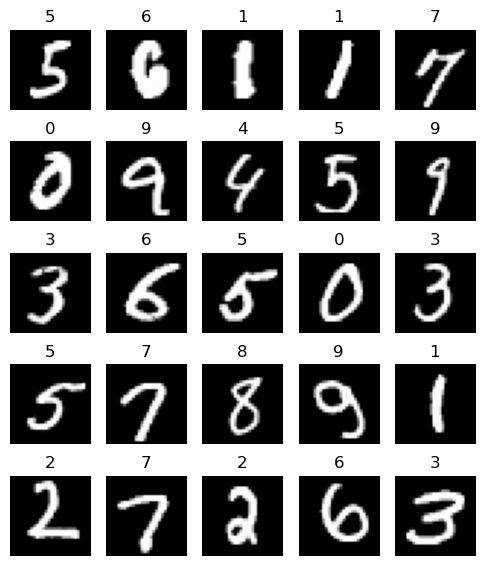

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def apply_network(net):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [9]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

In [10]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

apply_network(network)

forward 0.9973330497741699
forward 16.36217498779297
backward 0.033665020018815994
backward 0.19477495551109314


C:\dev\miniconda\envs\ds\Lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Теперь попробуем использовать инициализацию He:<br>
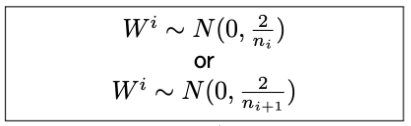

In [11]:
def he_init_layer(layer):
    init_layer(layer, 0, 2 / layer.in_features)

In [12]:
layer_1_he = nn.Linear(28*28, 500)
layer_2_he = nn.Linear(500, 10)

layer_1_he.register_forward_hook(forward_hook)
layer_2_he.register_forward_hook(forward_hook)

layer_1_he.register_backward_hook(backward_hook)
layer_2_he.register_backward_hook(backward_hook)

he_init_layer(layer_1_he)
he_init_layer(layer_2_he)

In [13]:
network_he = nn.Sequential(
    layer_1_he,
    nn.ReLU(),
    layer_2_he
)

apply_network(network_he)

forward 0.9973330497741699
forward 0.04274769499897957
backward 0.033665020018815994
backward 0.0008182094898074865


Соберем все вместе, используя ReLU в качестве функции активации:

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

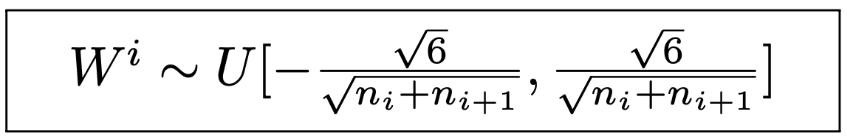

In [14]:
def xavier_init_layer(layer):
    init_layer(layer, 0, np.sqrt(2 / (layer.in_features + layer.out_features)))

In [15]:
layer_1_xav = nn.Linear(28*28, 500)
layer_2_xav = nn.Linear(500, 10)

layer_1_xav.register_forward_hook(forward_hook)
layer_2_xav.register_forward_hook(forward_hook)

layer_1_xav.register_backward_hook(backward_hook)
layer_2_xav.register_backward_hook(backward_hook)

xavier_init_layer(layer_1_xav)
xavier_init_layer(layer_2_xav)

In [16]:
network_xav = nn.Sequential(
    layer_1_xav,
    nn.Tanh(),
    layer_2_xav
)

apply_network(network_xav)

forward 0.9973330497741699
forward 0.6522994637489319
backward 0.033665020018815994
backward 0.012890647165477276


In [17]:
print("HE initialization")
apply_network(network_he)

print("Xavier initialization")
apply_network(network_xav)

HE initialization
forward 0.9973330497741699
forward 0.04274769499897957
backward 0.033665020018815994
backward 0.0008182094898074865
Xavier initialization
forward 0.9973330497741699
forward 0.6522994637489319
backward 0.033665020018815994
backward 0.012890647165477276


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

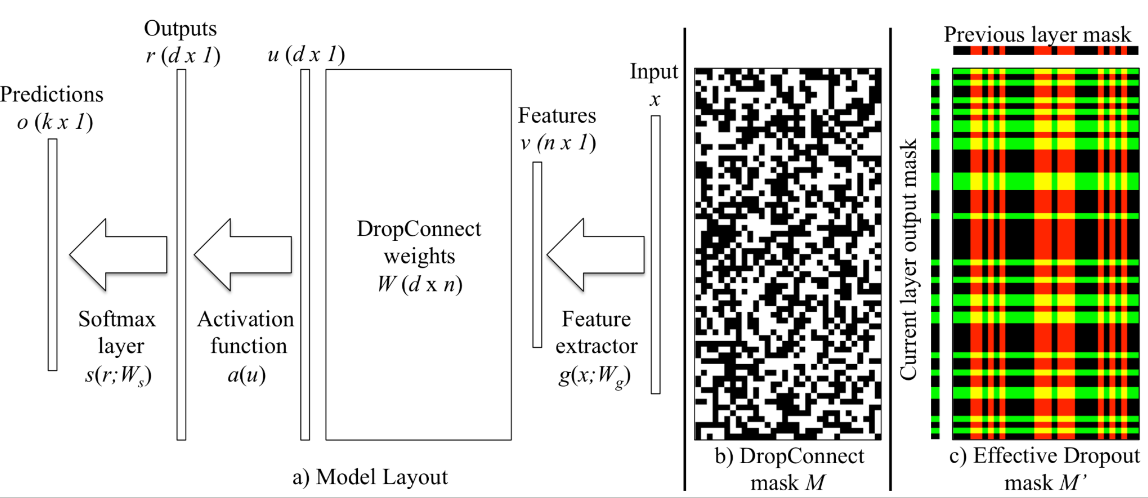

In [18]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = (torch.rand_like(self.linear.weight) > self.p)
        else:
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)

        mask = mask.data.requires_grad_(False)
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [19]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [20]:
layers = [
    nn.Linear(196, 256),
    nn.ReLU(),
    DropConnect(256, 256),

    nn.Linear(256, 256),
    nn.ReLU(),
    DropConnect(256, 256),

    nn.Linear(256, 128),
    nn.ReLU(),
    DropConnect(128, 128),

    nn.Linear(128, 64),
    nn.ReLU(),
    DropConnect(64, 64),

    nn.Linear(64, 10),
]

In [21]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [22]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319293
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.747739
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.239178
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.665536
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.521789
Test Epoch: 0	Loss: 0.472438
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.524473
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.428393
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.343102
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.518634
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.293243
Test Epoch: 1	Loss: 0.251138
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.336817
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.284786
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.186321
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.058233
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.225626
Test Epoch: 2	Loss: 0.146779
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.090665
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.130551
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.080766
Train Epoch: 3 [38400/60000 (64%)

Определим класс DropOut

In [23]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Добавим функцию обучения модели

In [24]:
from tqdm.auto import tqdm

class MNISTModel:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.device = torch.device('cpu')
    
    def create_plot(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_epochs, label='Train')
        plt.plot(self.val_loss_epochs, label='Val')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracy_epochs, label='Train accuracy')
        plt.plot(self.val_accuracy_epochs, label='Val accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
    def train_model(self, train_loader, val_loader, num_epochs=10, plot=True):
        try:
            self.train_loss_epochs = []
            self.val_loss_epochs = []
            self.train_accuracy_epochs = []
            self.val_accuracy_epochs = []
            
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                correct = 0
                total = 0
                
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    self.optimizer.zero_grad()
                    
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    
                    loss.backward()
                    self.optimizer.step()
                    
                    running_loss += loss.item()
                    predicted = torch.argmax(outputs, dim=1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                
                train_loss = running_loss / len(train_loader)
                train_acc = correct / total
                
                val_loss, val_acc = self.evaluate_model(val_loader)

                self.train_loss_epochs.append(train_loss)
                self.train_accuracy_epochs.append(train_acc)

                self.val_loss_epochs.append(val_loss)
                self.val_accuracy_epochs.append(val_acc)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                    f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
                
            if plot:
                self.create_plot()

        except KeyboardInterrupt:
            print("Interrupted")

            pass

    def evaluate_model(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        loss = running_loss / len(loader)
        accuracy = correct / total

        return loss, accuracy

C:\dev\miniconda\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
layers_dropconnect = [
    DropConnect(196, 256),
    nn.ReLU(),

    DropConnect(256, 256),
    nn.ReLU(),

    DropConnect(256, 128),
    nn.ReLU(),

    DropConnect(128, 64),
    nn.ReLU(),

    nn.Linear(64, 10),
]

layers_dropout = [
    nn.Linear(196, 256),
    nn.ReLU(),
    Dropout(),

    nn.Linear(256, 256),
    nn.ReLU(),
    Dropout(),

    nn.Linear(256, 128),
    nn.ReLU(),
    Dropout(),

    nn.Linear(128, 64),
    nn.ReLU(),
    Dropout(),

    nn.Linear(64, 10),
]

In [26]:
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))

optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)

criterion = torch.nn.CrossEntropyLoss()

model_dropconnect = MNISTModel(network_dropconnect, criterion, optimizer_dropconnect)
model_dropout = MNISTModel(network_dropout, criterion, optimizer_dropout)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:


 ... (more hidden) ...

Epoch [1/5], Loss: 1.3832, Accuracy: 0.4694, Val Loss: 0.6783, Val Accuracy: 0.7629


 ... (more hidden) ...

Epoch [2/5], Loss: 0.4010, Accuracy: 0.8687, Val Loss: 0.2364, Val Accuracy: 0.9300


 ... (more hidden) ...

Epoch [3/5], Loss: 0.1730, Accuracy: 0.9457, Val Loss: 0.1450, Val Accuracy: 0.9567


 ... (more hidden) ...

Epoch [4/5], Loss: 0.1198, Accuracy: 0.9626, Val Loss: 0.1183, Val Accuracy: 0.9631


 ... (more hidden) ...

Epoch [5/5], Loss: 0.0943, Accuracy: 0.9704, Val Loss: 0.0923, Val Accuracy: 0.9712


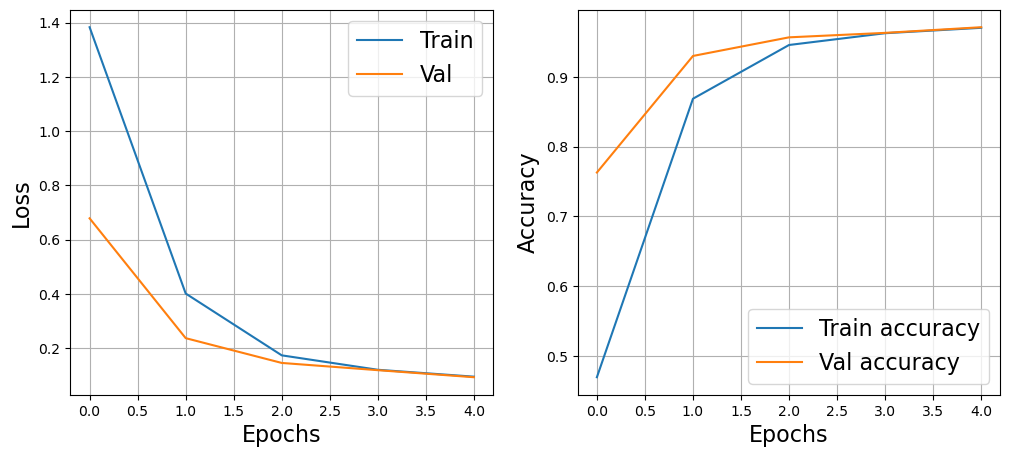

In [27]:
model_dropconnect.train_model(train_loader=train_loader, val_loader=test_loader, num_epochs=5)

 ... (more hidden) ...

Epoch [1/5], Loss: 1.0907, Accuracy: 0.6135, Val Loss: 0.8535, Val Accuracy: 0.9172


 ... (more hidden) ...

Epoch [2/5], Loss: 0.2138, Accuracy: 0.9400, Val Loss: 0.1399, Val Accuracy: 0.9591


 ... (more hidden) ...

Epoch [3/5], Loss: 0.1300, Accuracy: 0.9611, Val Loss: 0.1163, Val Accuracy: 0.9648


 ... (more hidden) ...

Epoch [4/5], Loss: 0.1032, Accuracy: 0.9693, Val Loss: 0.0998, Val Accuracy: 0.9714


 ... (more hidden) ...

Epoch [5/5], Loss: 0.0839, Accuracy: 0.9753, Val Loss: 0.0840, Val Accuracy: 0.9762


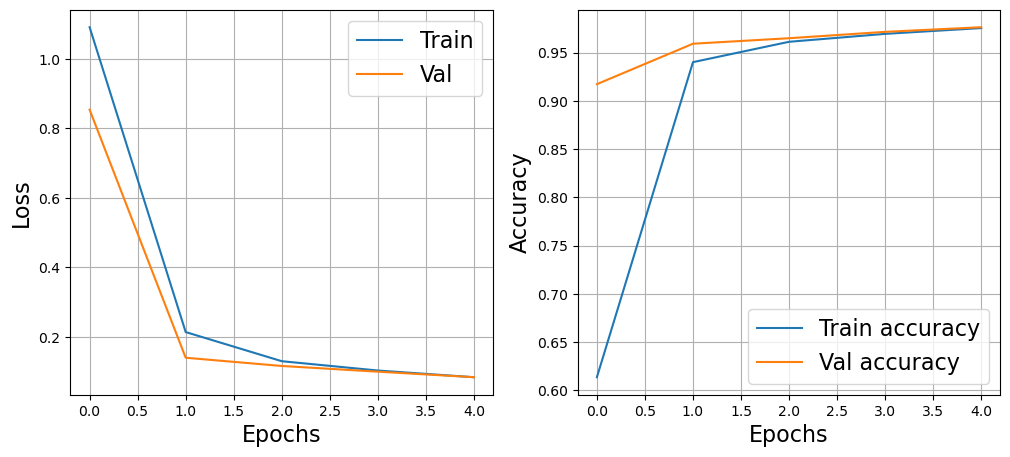

In [28]:
model_dropout.train_model(train_loader=train_loader, val_loader=test_loader, num_epochs=5)

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

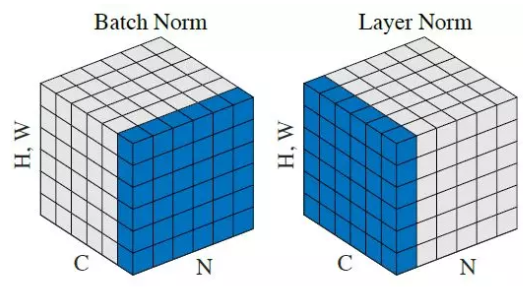

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

Добавим реализацию Batch Normalization

In [37]:
class BatchNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalization, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)



    def forward(self, input):
        if self.training:
            mean = input.mean(0)
            var = input.var(0, unbiased=False)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :]) / (torch.sqrt(var[None, :] + self.eps))
        return input

Реализация Layer Normalization

In [39]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(LayerNormalization, self).__init__()
        
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)

        output = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return output

In [38]:
layers_batch_normalization = [
    nn.Linear(196, 256),
    nn.ReLU(),
    BatchNormalization(256),

    nn.Linear(256, 256),
    nn.ReLU(),
    BatchNormalization(256),

    nn.Linear(256, 128),
    nn.ReLU(),
    BatchNormalization(128),

    nn.Linear(128, 64),
    nn.ReLU(),
    BatchNormalization(64),

    nn.Linear(64, 10),
]

layers_layer_normalization = [
    nn.Linear(196, 256),
    nn.ReLU(),
    LayerNormalization(256),

    nn.Linear(256, 256),
    nn.ReLU(),
    LayerNormalization(256),

    nn.Linear(256, 128),
    nn.ReLU(),
    LayerNormalization(128),

    nn.Linear(128, 64),
    nn.ReLU(),
    LayerNormalization(64),

    nn.Linear(64, 10),
]

In [40]:
network_batch_normalization = TestNetwork(nn.Sequential(*layers_batch_normalization))
network_layer_normalization = TestNetwork(nn.Sequential(*layers_layer_normalization))

optimizer_batch_normalization = torch.optim.Adam(network_batch_normalization.parameters(), lr=0.001)
optimizer_layer_normalization = torch.optim.Adam(network_layer_normalization.parameters(), lr=0.001)

criterion = torch.nn.CrossEntropyLoss()

model_batch_normalization = MNISTModel(network_batch_normalization, criterion, optimizer_batch_normalization)
model_layer_normalization = MNISTModel(network_layer_normalization, criterion, optimizer_layer_normalization)

 ... (more hidden) ...

Epoch [1/5], Loss: 0.2338, Accuracy: 0.9346, Val Loss: 0.0973, Val Accuracy: 0.9681


 ... (more hidden) ...

Epoch [2/5], Loss: 0.1141, Accuracy: 0.9651, Val Loss: 0.0894, Val Accuracy: 0.9733


 ... (more hidden) ...

Epoch [3/5], Loss: 0.0806, Accuracy: 0.9742, Val Loss: 0.0802, Val Accuracy: 0.9754


 ... (more hidden) ...

Epoch [4/5], Loss: 0.0645, Accuracy: 0.9793, Val Loss: 0.0795, Val Accuracy: 0.9749


 ... (more hidden) ...

Epoch [5/5], Loss: 0.0566, Accuracy: 0.9817, Val Loss: 0.0785, Val Accuracy: 0.9783


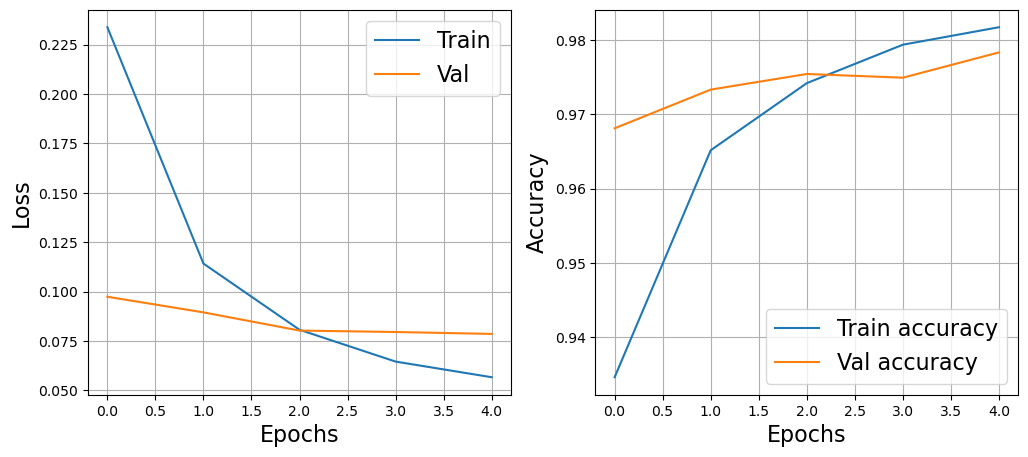

In [41]:
model_batch_normalization.train_model(train_loader=train_loader, val_loader=test_loader, num_epochs=5)

 ... (more hidden) ...

Epoch [1/5], Loss: 0.2523, Accuracy: 0.9289, Val Loss: 0.1113, Val Accuracy: 0.9674


 ... (more hidden) ...

Epoch [2/5], Loss: 0.1008, Accuracy: 0.9686, Val Loss: 0.1142, Val Accuracy: 0.9650


 ... (more hidden) ...

Epoch [3/5], Loss: 0.0755, Accuracy: 0.9763, Val Loss: 0.0805, Val Accuracy: 0.9742


 ... (more hidden) ...

Epoch [4/5], Loss: 0.0585, Accuracy: 0.9815, Val Loss: 0.0770, Val Accuracy: 0.9778


 ... (more hidden) ...

Epoch [5/5], Loss: 0.0489, Accuracy: 0.9847, Val Loss: 0.0702, Val Accuracy: 0.9795


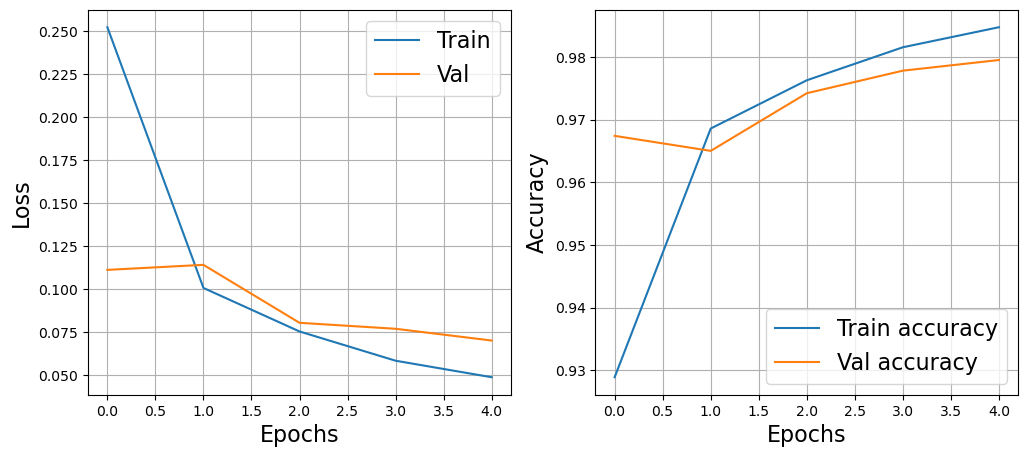

In [36]:
model_layer_normalization.train_model(train_loader=train_loader, val_loader=test_loader, num_epochs=5)

### Выводы

HE Initialization vs Xavier Initialization
- По результатам видно, что использование ReLU + HE показывает лучшие результаты;
- Среднеквадратическое отклонение у HE гораздо лучше;
- Симметричные функции активации и Xavier могут показать более приемлимые результаты на простых нейронках;

Dropout vs Dropconnect
- Показывают приблизително одинаковые результаты, быстрая сходимость за 5 эпох;
- Dropout показывает несколько более хороший результат;

Batch Normalization vs Layer Normalization
- Результаты практически идентичные, результаты Batch Normalization выглядят более стабильными.